# Predict Hunger: Data Cleaning

In [2]:
## Import packages
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import math
import missingno as msno
import warnings
from sklearn import preprocessing

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style('darkgrid')

In [3]:
#loading data
labels = pd.read_csv('Predicting_Chronic_Hunger_Training_labels.csv', index_col="row_id")
train = pd.read_csv('Predicting_Chronic_Hunger_Training_values.csv', index_col="row_id")
test = pd.read_csv('Predicting_Chronic_Hunger_Test_values.csv', index_col="row_id")

In [4]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('-------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],train.shape[1]))

The train data has 1401 rows and 45 columns
-------------------------------------------
The test data has 616 rows and 45 columns


## Relationships between variables
We will first check for collinear features, and see which features show strong correlation with the target variable "undernourishment".

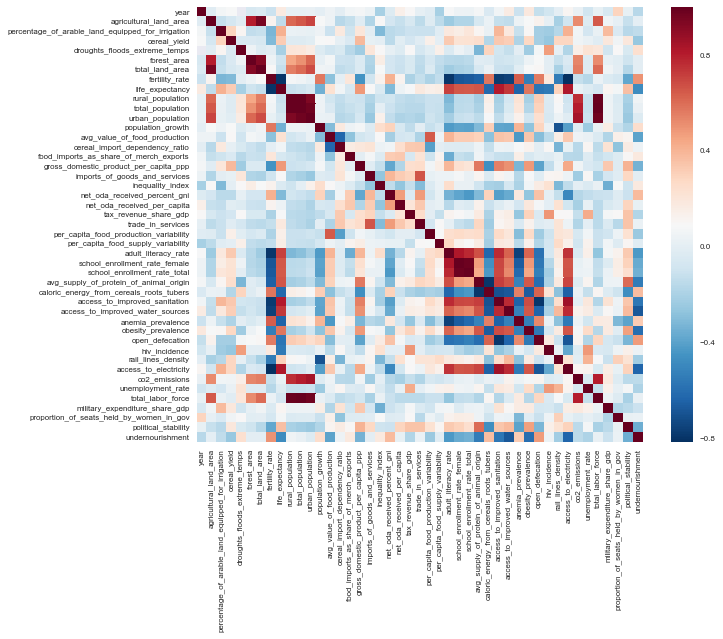

In [5]:
train_corr = train.copy()
train_corr['undernourishment'] = labels
corr = train_corr.corr()
plt.figure(figsize=(10,8))
sns.set(font_scale=0.8)
sns.heatmap(corr,cmap="RdBu_r")

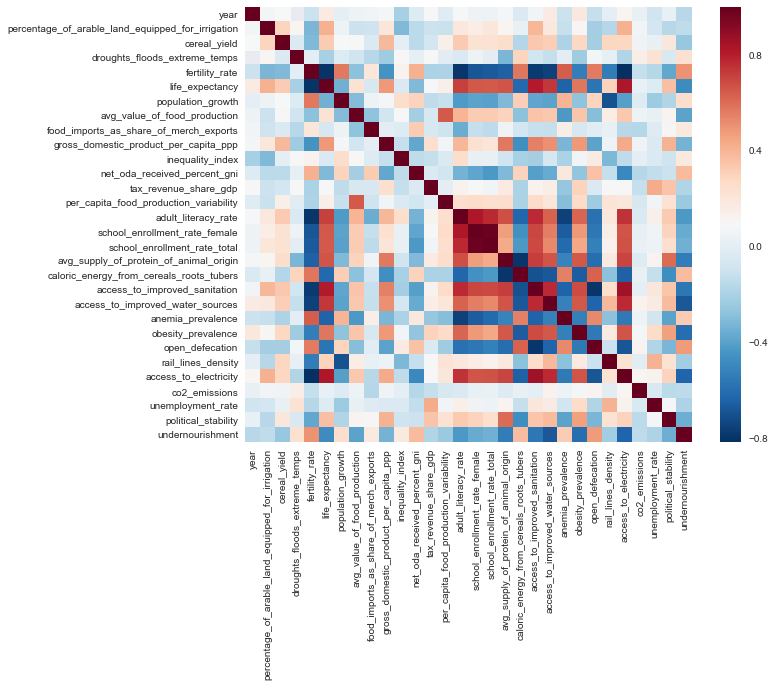


30 features have an absolute pearson r coefficient higher than 0.1 

Top 5 features with higher and lower pearson r coef: 

fertility_rate                              0.497108
open_defecation                             0.479173
net_oda_received_percent_gni                0.377888
caloric_energy_from_cereals_roots_tubers    0.373514
anemia_prevalence                           0.321443
Name: undernourishment, dtype: float64
----------------------
avg_supply_of_protein_of_animal_origin   -0.542252
access_to_improved_sanitation            -0.562945
obesity_prevalence                       -0.600513
access_to_electricity                    -0.634076
access_to_improved_water_sources         -0.675150
Name: undernourishment, dtype: float64


In [6]:
def corr_mat(data, dep_feature, thresh, details = False):
    corr = data.corr()
    low_corr = corr[corr[dep_feature].abs() < thresh].index # Features with very low correlation with undernourishment
    corr = corr.drop(low_corr, axis = 1)
    corr = corr.drop(low_corr, axis = 0)
    
    plt.figure(figsize=(10,8))
    sns.set(font_scale=1)
    sns.heatmap(corr,cmap="RdBu_r")
    plt.show()
    
    print("\n{0} features have an absolute pearson r coefficient higher than {1} \n".format(corr['undernourishment'].shape[0], thresh))
    
    if details == True:
        print("Top 5 features with higher and lower pearson r coef: \n")
        print (corr['undernourishment'].sort_values(ascending=False)[:6].iloc[1:])  #top 10 values
        print ('----------------------')
        print (corr['undernourishment'].sort_values(ascending=False)[-5:])          #last 10 values



train_corr = train.copy()
train_corr['undernourishment'] = labels.iloc[train_corr.index]
corr_mat(train_corr, 'undernourishment', 0.1, details=True)

# Filling missing values

- We group datapoints by country_code and year, and impute the series' with its mean or by interpolation (in both direction).
- We remove features with either too many missing values or weakly correlated with the dependant variable 'undernourishment'.
- We remove countries for which all values are missing in more than 8 features.

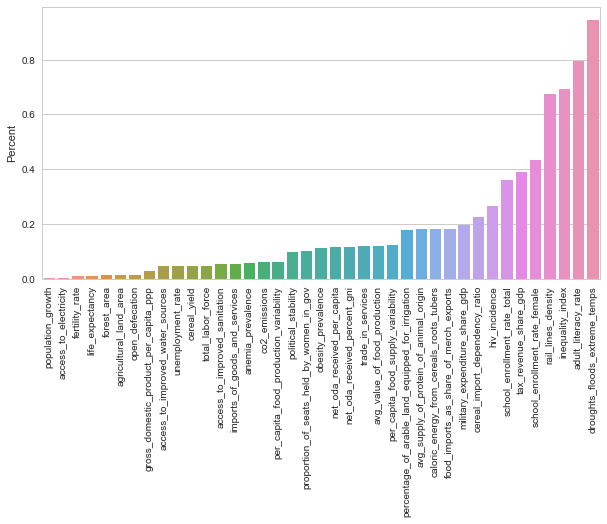

In [7]:
def missing(data):
    """Returns a dataframe with absolute number of missing values and fractions per features."""
    total = data.isnull().sum().sort_values()
    percent = (data.isnull().sum()/data.isnull().count()).sort_values()
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data["Percent"] > 0]

def missing_visualize(miss):
    """Barplot plotting of missing values fraction per feature."""
    #visualizing missing values
    plt.figure(figsize=(10,5))
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x = miss.index, y = 'Percent', data=miss)
    plt.xticks(rotation = 90)
    plt.show()

    
# create missing values fraction dataframe
miss = missing(train)
#miss

# bar plot of missing values fractions
missing_visualize(miss)

Some of the strongly correlated features have more than 15% of missing values (school_enrollment_rate_female, caloric_energy_from_cereals_roots_tubers, avg_supply_of_protein_of_animal_origin). We see that the year is weakly correlated (pearson c > 0.156), so in order to avoid losing too much information, and considering the dataset includes times series of 5 to 16 years, it seems a rather good option to try interpolate countries series ordered per year or fill missing values with the mean. <br>

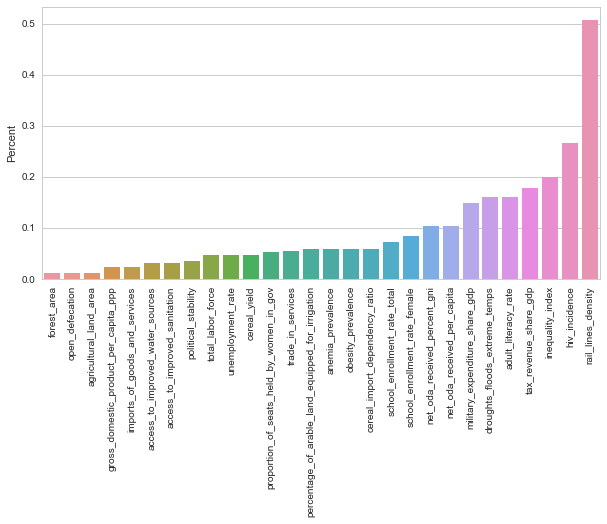

In [8]:
def imputation(data, method):
    """Impute the mean or interpolate when values are partially missing. Input is {data:data,
                                                                                   method:['interpolate', 'mean']
    Return the transformed dataframe.
    """
    num_cols = [col for col in train.columns if train[col].dtype == 'float64']
    train_by_country = data.groupby('country_code')
    for key, group in train_by_country:
        for ft in num_cols:
            if (group[ft].isna().all() != True) & (group[ft].isna().any()):
                idx = data['country_code']==key
                temp = data.loc[idx,ft]
                if method == 'mean':
                    data.loc[idx,ft] = temp.fillna(np.mean(temp))   
                if method == 'interpolation':
                    data.loc[idx,ft] = temp.interpolate(limit_direction='both')
    return data

train = imputation(train, method='mean')
miss = missing(train)
missing_visualize(miss)

We can see that after imputing values, we either filled all the missing values or significantly reduced it (up to 30% less for some features). Deciding to remove features that have either too many missing values (>10%) or low correlation (pearson r coef <0.2) with the dependant variable now seems reasonable.

In [9]:
train.drop(['military_expenditure_share_gdp', 'hiv_incidence', 'inequality_index', 
            'droughts_floods_extreme_temps', 'rail_lines_density', 'tax_revenue_share_gdp', 
            'net_oda_received_per_capita'], axis=1, inplace=True)

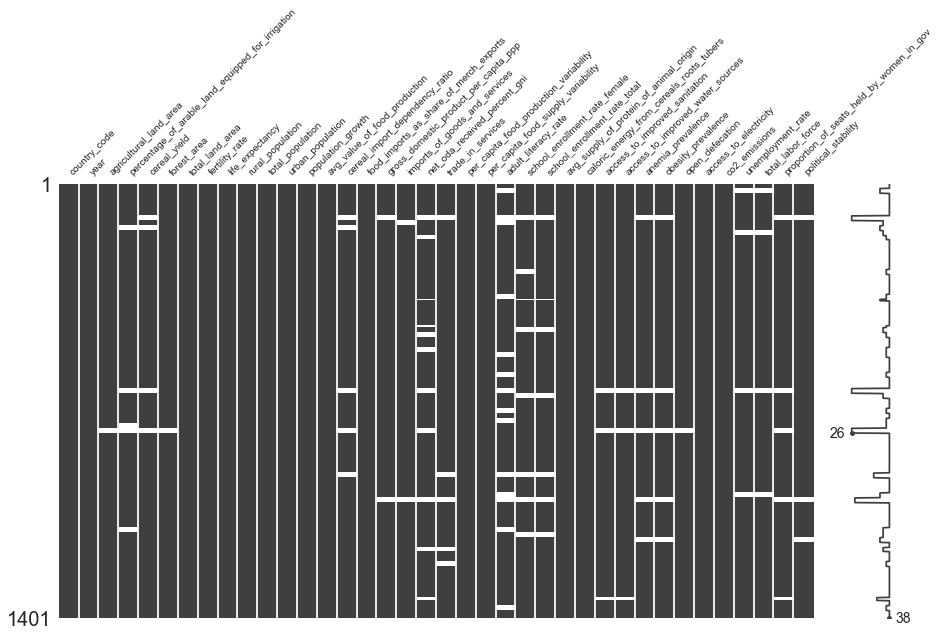

In [10]:
msno.matrix(train.sort_values('country_code'), figsize=(15,8), fontsize=10)

We can see there are 4 countries with more than 10 features with only null values, and will remove them because they are more likely to introducing bias than adding information.

In [11]:
def country_frame(train, threshold, test=False):
    """Create a dataframe with country means instead of time series.
    Remove the countries that have a number of features with only missing values above the threshold.
    """
    
    train_by_country = train.groupby('country_code')
    country = pd.DataFrame(index = train_by_country.groups)
    
    for col in [col for col in train.columns if train[col].dtype == 'float64']:
        country[col] = train_by_country[col].mean()
        
    if test == True: #Print test
        print("Number of countries before dropping: " + str(country.shape[0]))
        country.dropna(thresh=(len(country.columns) - threshold), inplace = True)
        print("Number of countries after dropping: " + str(country.shape[0]))
    
    return country


# Create the reduced country dataframe
country = country_frame(train, 10, test=True)                 # Set test = True and comment underneath to test

Number of countries before dropping: 92
Number of countries after dropping: 88


In [12]:
index = []
country_lst = [x for x in train.country_code.unique()         # Create list of countries to remove
               if x not in list(country.index)]

for code in country_lst:
    index.append(train[train.country_code == code].index)     #list of the 8 countries' datapoints' indexes
    
index = [item for sublist in index for item in sublist]       #flatten list
train.drop(index, inplace=True)                               #remove countries

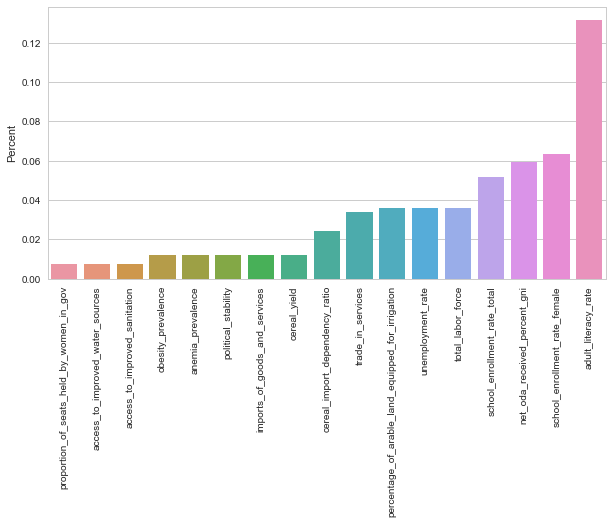

In [13]:
miss = missing(train)
missing_visualize(miss)

In [14]:
## Impute feature's median when there's no values:
for col in train.columns[2:]:
     train[col] = train[col].fillna(country[col].median())

Clean the missing value from the test dataset

In [15]:
# test features cleaning:
test = test[train.columns]                               # select only the columns of train dataset
test = imputation(test, method='mean')                   # impute mean to missing values

country = country_frame(test, 0)                        
for col in test.columns[2:]:
     test[col] = test[col].fillna(country[col].median()) # if we remove any datapoints, shape won't match the grader's test labels shape

In [16]:
print('After cleaning the missing values: \n')
print('The train dataset has {0} entries and {1} columns'.format(train.shape[0],train.shape[1]))
print('--------------------------------------------------')
print('The test dataset has {0} entries and {1} columns'.format(test.shape[0],test.shape[1]))

After cleaning the missing values: 

The train dataset has 1337 entries and 38 columns
--------------------------------------------------
The test dataset has 616 entries and 38 columns


In [17]:
train.to_csv('Cleaned_Train.csv')
test.to_csv('Cleaned_Test.csv')

# Predict Hunger : Feature Engineering & Elimination

In [18]:
#loading data
train = pd.read_csv('Cleaned_Train.csv', index_col="row_id")
labels = pd.read_csv('Predicting_Chronic_Hunger_Training_labels.csv', index_col="row_id")
test = pd.read_csv('Cleaned_Test.csv', index_col="row_id")

In [19]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('-------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],train.shape[1]))

The train data has 1337 rows and 38 columns
-------------------------------------------
The test data has 616 rows and 38 columns


## First insights on which model to use

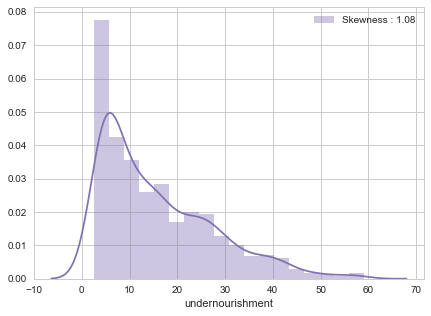

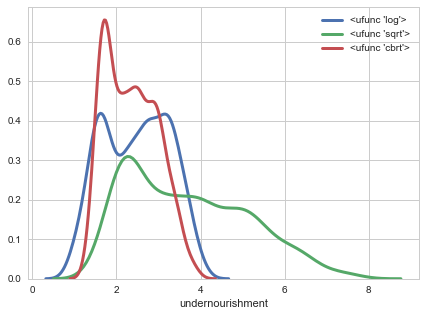

In [20]:
#Add undernourishment to the features
train['undernourishment'] = labels

#Plot the undernourishment distribution
plt.figure(1, figsize=(7,5))
g = sns.distplot(train['undernourishment'], color='m', label="Skewness : %.2f"%(train['undernourishment'].skew()))
g = g.legend(loc='best')
target = np.log(train['undernourishment'])
plt.show()

plt.figure(1, figsize=(7,5))
method = [np.log, np.sqrt, np.cbrt] 
for x in method:
    subset = x(train['undernourishment'])
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = x)

The dependant variable we try to predict is right skewed, and it is unlikely that we can precisely predict the "outliers" in the tail of the distribution. However, transforming with natural logarithm, cube root or square root the variable results in a bimodal or skewed distribution which isn't an improvment. Therefore, we will have to choose a model that doesn't assume the normality of the dependant variable (e.g. not a linear regression, but rather SVM or RandomForest for instance). <br>

**_Note:_** Such types of models of regression can spot non-linear relationship, so we will keep all the features supposing that there may be explanative strong non-linear relationships that aren't represented by the pearson r coef.

## Features with low variance

Features with low variance might add very little information to the model.

In [21]:
def variance(data):
    """Returns the variance of normalized data."""
    num = [f for f in data.columns if train[f].dtype=='float64']
    scale = preprocessing.normalize(data[num])
    scaled = pd.DataFrame(columns=num)
    
    idx, variance = 0, []
    
    for x in num:
        scaled[x] = scale[:,idx]
        idx = idx+1
        variance.append(scaled[x].var())
        
    variance.sort(reverse=True)
    variance = ['{:0.2e}'.format(x) for x in variance]
    return pd.DataFrame(variance, index = num, columns = ['variance'])

variance(train)[-5:] # 5 features with the lowest variance

,variance
unemployment_rate,8.16e-11
total_labor_force,7.77e-11
proportion_of_seats_held_by_women_in_gov,8.06e-12
political_stability,1.28e-12
undernourishment,8.77e-13


The features with the lowest variance might still be relevant to predict the dependant variable. Fertility_rate for instance is highly correlated to the dependant variable. We won't remove those features for now.

In [22]:
def collinear_pairs(data, correlation_thresh):
    """Returns a dataframe of the features that are more correlated than the specified threshold."""    
    corr = data.corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))                   # Create correlation matrix and mask the upper part
    to_drop = [column for column in upper.columns if 
               any(upper[column].abs() > correlation_thresh)]                                 # Select the features with correlations above the threshold
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value']) # Create the dataframe
    for column in to_drop:
        corr_features = list(upper.index[upper[column].abs() > correlation_thresh])           # Find the correlated features
        corr_values = list(upper[column][upper[column].abs() > correlation_thresh])           # Find the correlated values
        drop_features = [column for _ in range(len(corr_features))]        
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,                      # Record the information (need a temp df for now)
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)      
    return record_collinear


collinear = collinear_pairs(train, 0.95)['drop_feature'].unique()
collinear_pairs(train, 0.95)

,drop_feature,corr_feature,corr_value
0,total_land_area,agricultural_land_area,0.954481
1,total_population,rural_population,0.993398
2,urban_population,total_population,0.972766
3,school_enrollment_rate_total,school_enrollment_rate_female,0.978534
4,total_labor_force,rural_population,0.989735
5,total_labor_force,total_population,0.997858
6,total_labor_force,urban_population,0.974144


Highly correlated features add nothing but complexity to our model. 
We will however use them to create new features, and check the relationship of those new features before deciding to add them to our datasets.  

In [23]:
def create_features(data):
    ## Train set:
    data["urban_population_share"] = data["urban_population"]/data["total_population"] * 100
    data["co2em_share"] = np.log((data["co2_emissions"]/data["total_population"]) * 1000)

create_features(train)
create_features(test)

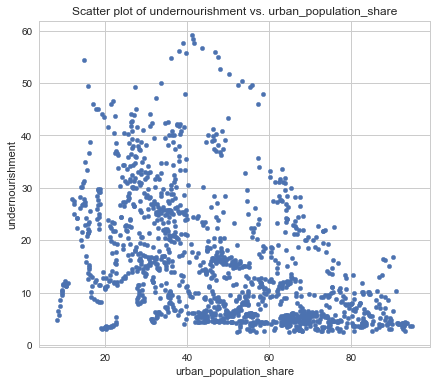

                        undernourishment  urban_population_share
undernourishment                1.000000               -0.471304
urban_population_share         -0.471304                1.000000


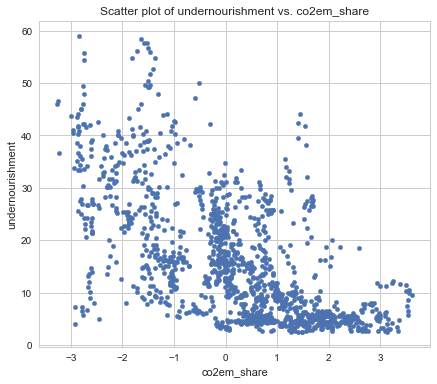

                  undernourishment  co2em_share
undernourishment          1.000000    -0.639888
co2em_share              -0.639888     1.000000


In [24]:
def plot_scatter_new_feature(data, cols, col_y = 'undernourishment'):
    for col in cols:
        fig = plt.figure(figsize=(7,6)) # define plot area
        ax = fig.gca() # define axis   
        data.plot.scatter(x = col, y = col_y, ax = ax)
        ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel(col_y)# Set text for y axis
        plt.show()
        print(data[["undernourishment", col]].corr())
        
new_ft = ["urban_population_share", "co2em_share"]
plot_scatter_new_feature(train, new_ft)

Using higly collinear features, we create 2 features that seem moderately correlated with undernourishment: the person of people living in urban area and the co2 emissions per habitant.

In [25]:
# Remove collinear features:
train.drop(['total_land_area', 'total_population', 'urban_population',
            'school_enrollment_rate_total', 'total_labor_force'], axis=1, inplace=True)
test.drop(['total_land_area', 'total_population', 'urban_population',
            'school_enrollment_rate_total', 'total_labor_force'], axis=1, inplace=True)

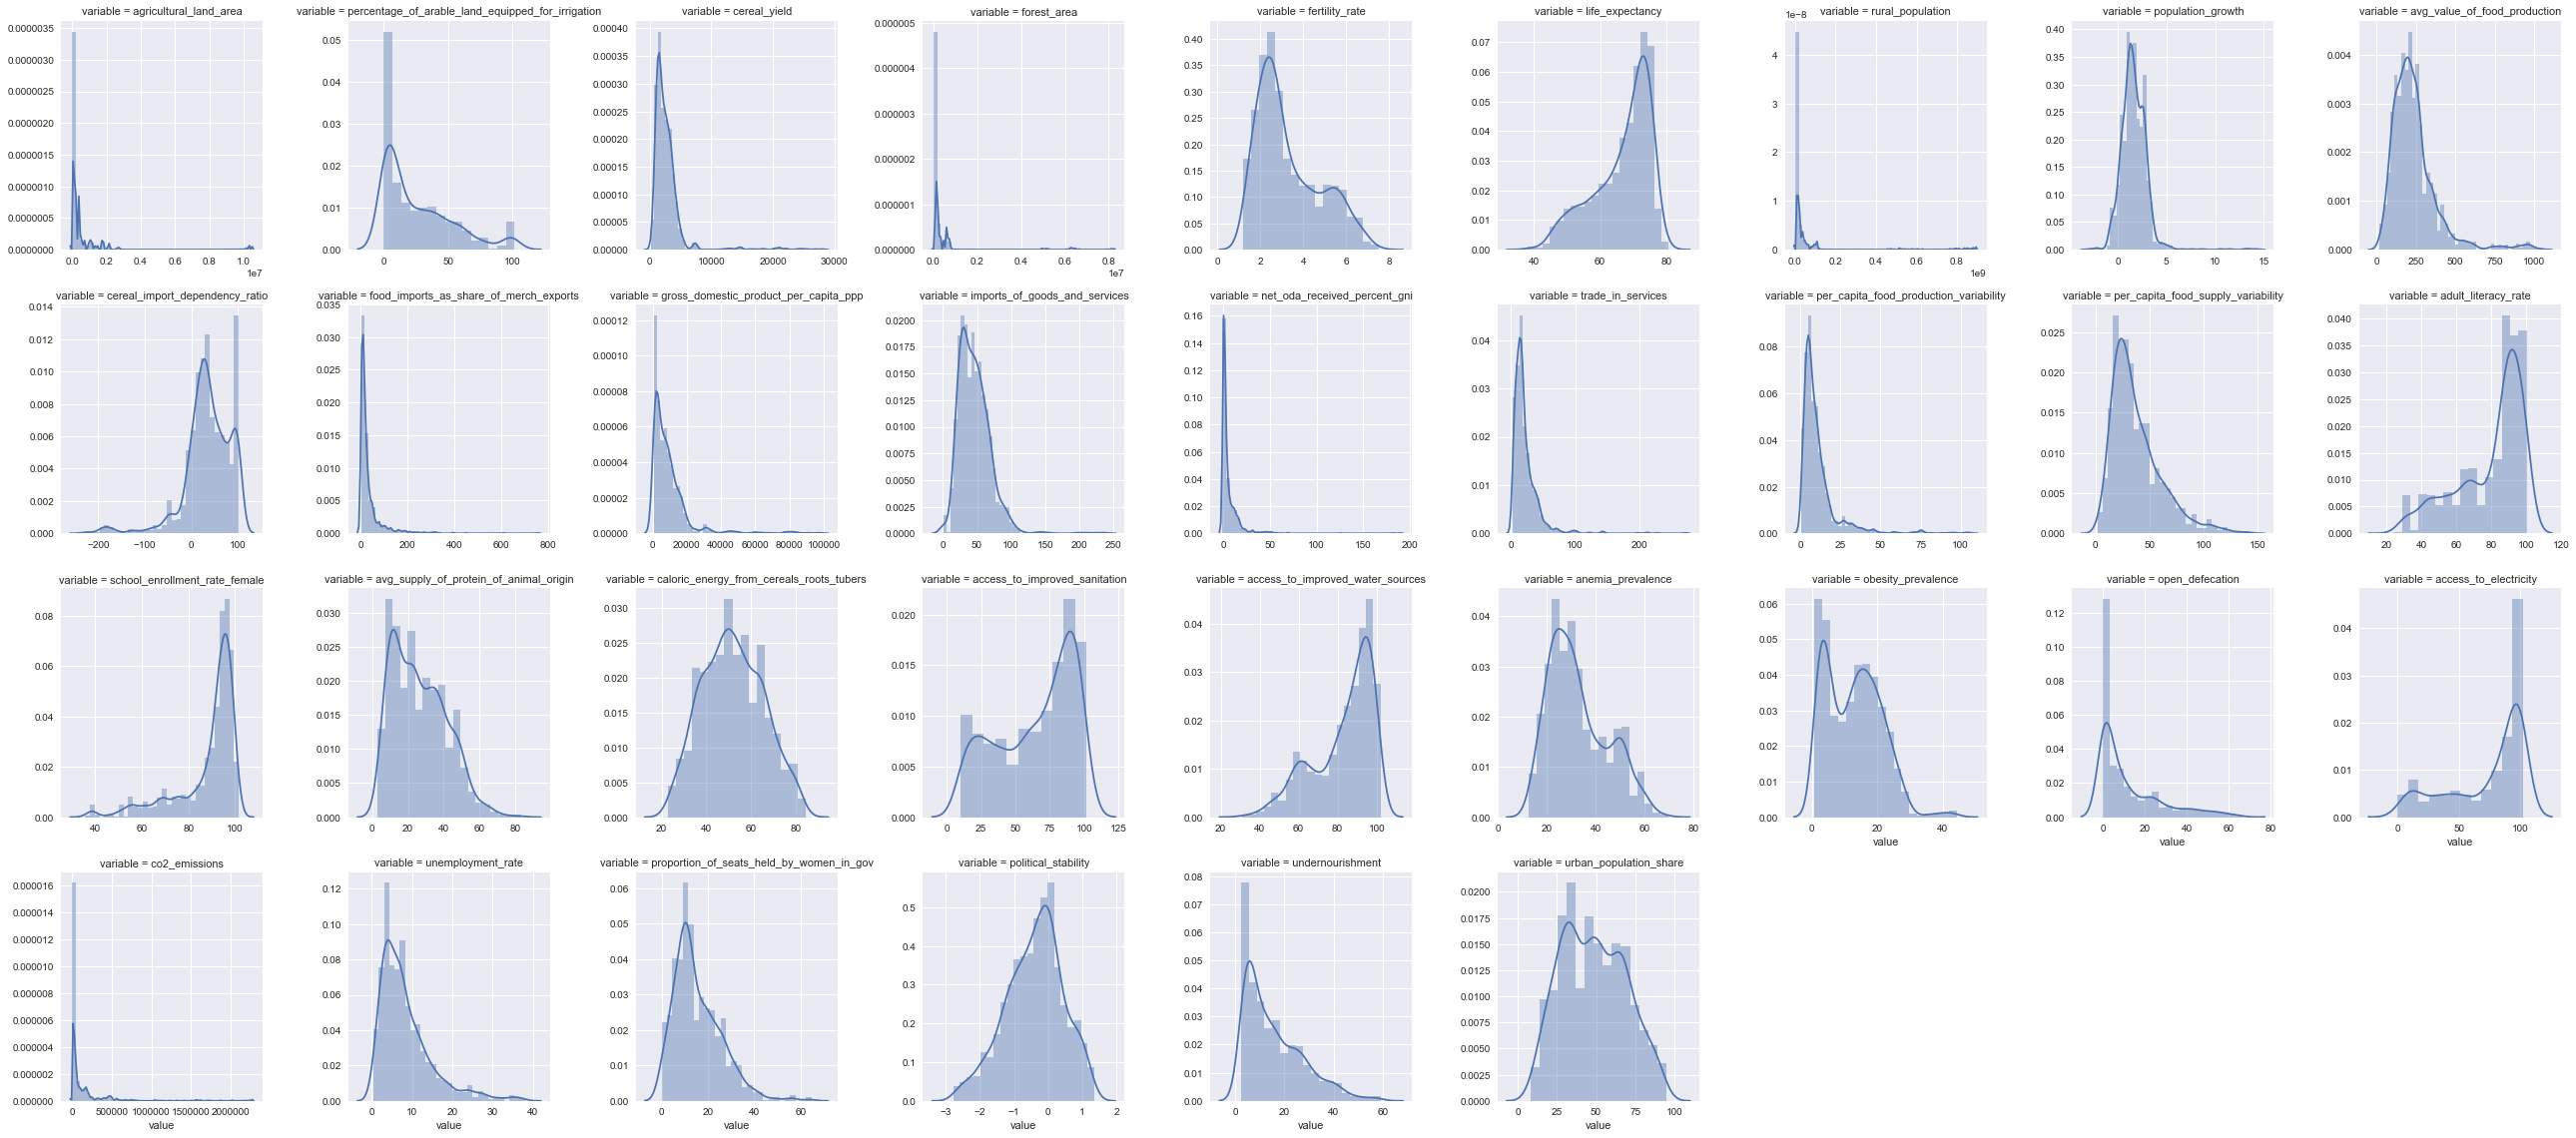

In [26]:
#create numeric plots to check features distribution
sns.set_style('darkgrid')
nd = pd.melt(train, value_vars = train.columns[2:-1]) # select all columns but country_code, year
n1 = sns.FacetGrid(nd, col='variable', col_wrap=9, sharex=False, sharey = False, size=4)
n1 = n1.map(sns.distplot, 'value')
n1

We notice that:
- The ranges of our variable considerably differ, and scaling is to be considerate depending on the algorithm used
- Many variables are severely right skewed, which might be the indicator of the presence of outliers
- The left skewed variables are measured in percentage in case we'd like to reverse them

The following code help spot the presence of outliers: We identify the skewed features, visualize them and check lower and high ranges of datapoints' standard deviation of the mean.

In [27]:
skewed = train[train.columns[2:]].apply(lambda x: ss.skew(x.abs().astype(float)))
print(skewed[skewed > 2].index) # print the features to inspect

Index(['agricultural_land_area', 'cereal_yield', 'forest_area',
       'rural_population', 'population_growth', 'avg_value_of_food_production',
       'food_imports_as_share_of_merch_exports',
       'gross_domestic_product_per_capita_ppp', 'net_oda_received_percent_gni',
       'trade_in_services', 'per_capita_food_production_variability',
       'co2_emissions'],
      dtype='object')


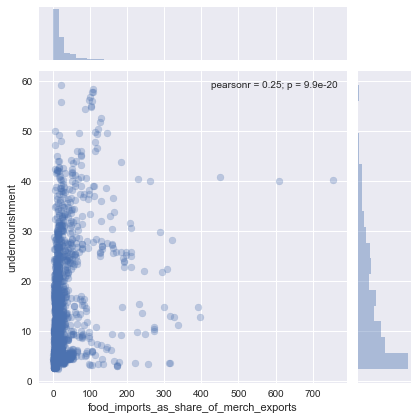

   low_range  high_range
0  -0.581752    6.260035
1  -0.581471    6.381873
2  -0.581335    7.301745
3  -0.581280   10.098420
4  -0.564606   12.658929


In [28]:
def outliers(data, col, detail=False, detail_lenght=10):
    """Returns the low and high outer range of col in terms of standard deviation."""
    sns.jointplot(x=data[col], y=train['undernourishment'], alpha=0.3)
    plt.show()
    
    if detail == True:
        ranges=pd.DataFrame()
        col_scaled = preprocessing.StandardScaler().fit_transform(data[col][:,np.newaxis]);
        ranges['low_range'] = [y for x in col_scaled[col_scaled[:,0].argsort()][:detail_lenght] for y in x]
        ranges['high_range'] = [y for x in col_scaled[col_scaled[:,0].argsort()][-detail_lenght:] for y in x]
        print(ranges)

outliers(train, 'food_imports_as_share_of_merch_exports', detail=True, detail_lenght=5) ## 2 potential outliers

We notice potential outliers for food_imports_as_share_of_merch_exports, net_oda_received_percent_gni, trade_in_services. However, after cheking into the dataframe it looks like the unusual of net_oda_received_percent_gni, trade_in_services concerns the same countries over the period of 2007 to 2010. Furthermore when we check, those points correspond to ver high rate of undernourishment (>35%). It might reflects occasional event of which the repercussions might be relevant to predict our dependant variable. We will therefore leave them as they are.

In [29]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('-------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],train.shape[1]))

The train data has 1337 rows and 36 columns
-------------------------------------------
The test data has 616 rows and 36 columns


In [30]:
train.drop('undernourishment', axis=1, inplace = True)
train.to_csv('Transformed_Train.csv')
test.to_csv('Transformed_Test.csv')

# Predict Hunger: Feature Transformation

We will save another datasets with unskewed data. Reducing the ranges of our variable is likely to improve the results of SVM regression. 

In [31]:
# Loading data
train = pd.read_csv('Transformed_Train.csv', index_col="row_id")
labels = pd.read_csv('Predicting_Chronic_Hunger_Training_labels.csv', index_col="row_id")
test = pd.read_csv('Transformed_Test.csv', index_col="row_id")

In [32]:
skewed = train[train.columns[2:]].apply(lambda x: ss.skew(x.astype(float)))
skewed = skewed[skewed > 0.75].index

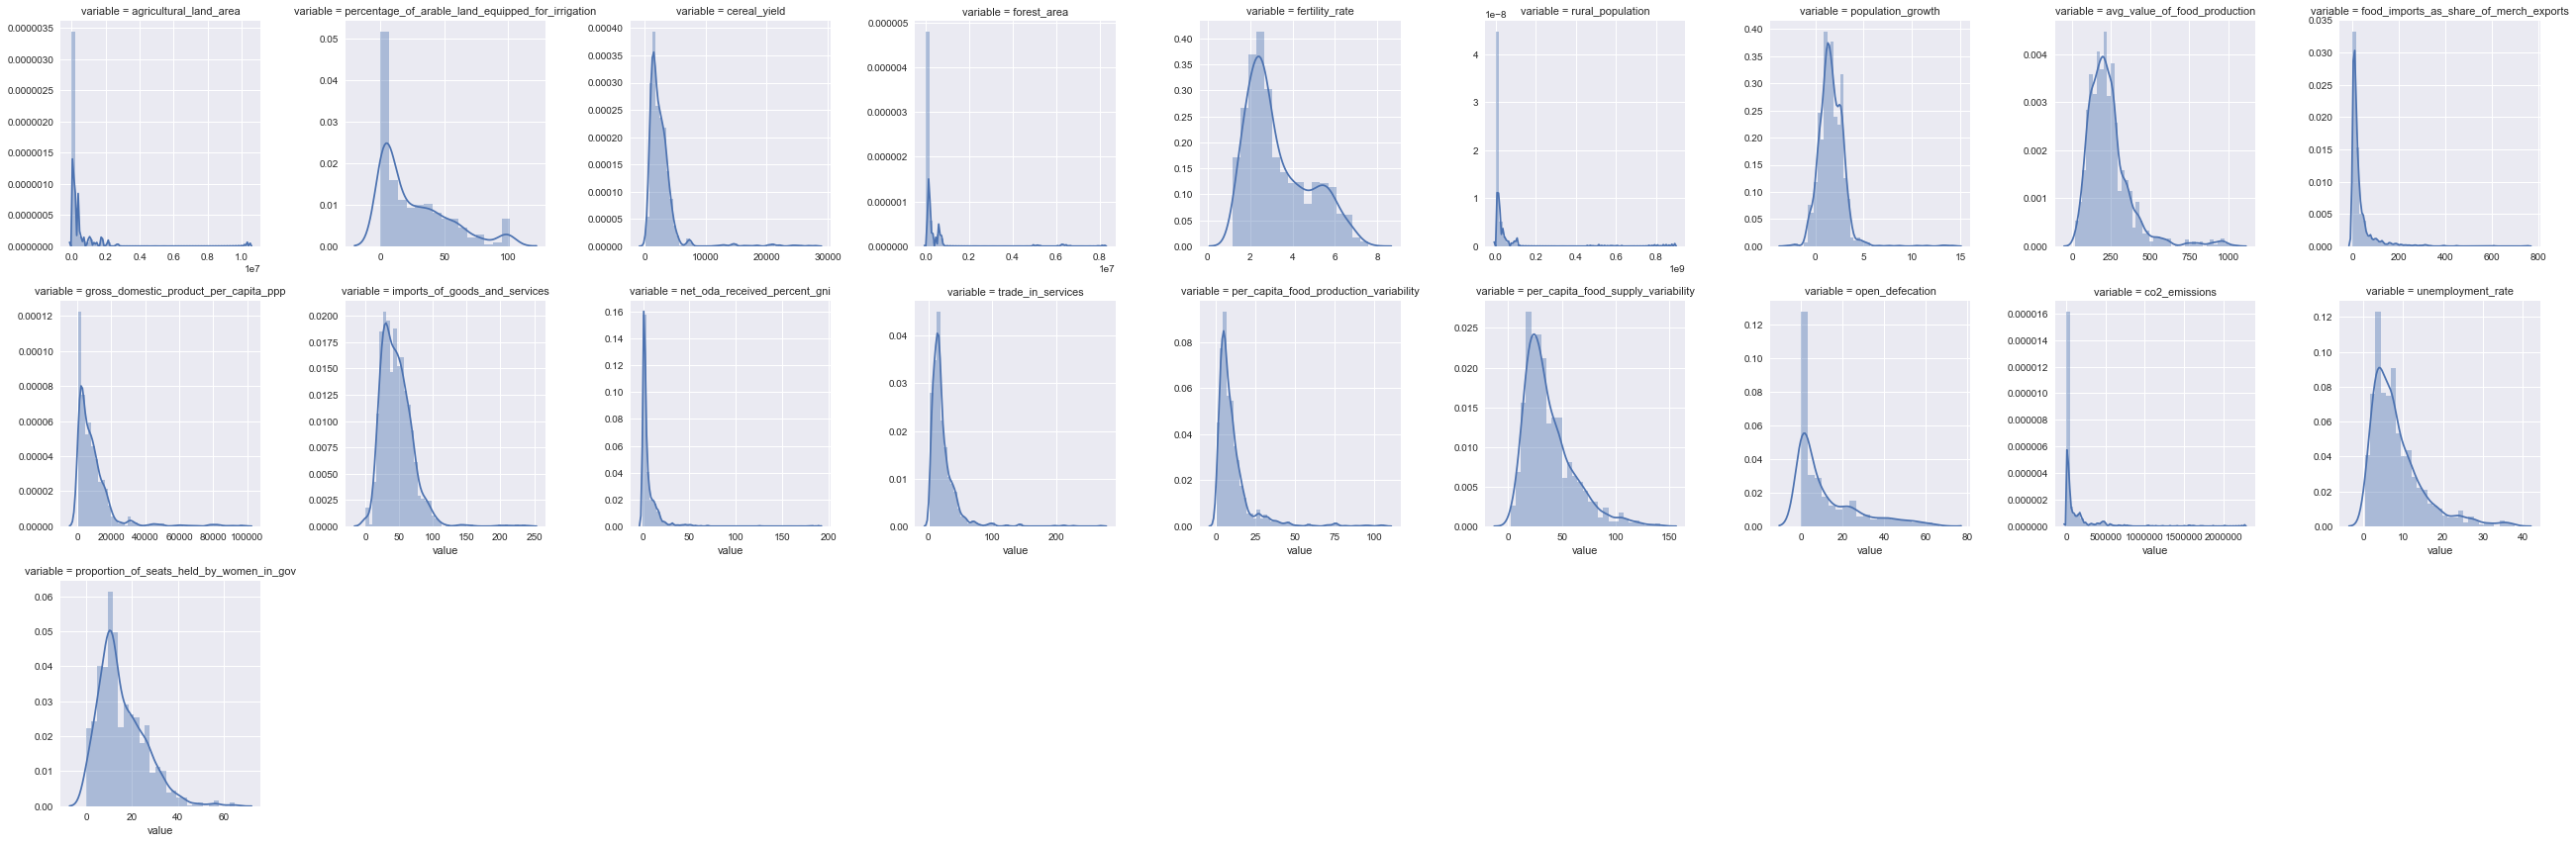

In [33]:
def facet_plotting(data, cols, nb_cols = 9):
    sns.set_style('darkgrid')
    nd = pd.melt(data, value_vars = train[cols]) # select all columns but country_code, year
    n1 = sns.FacetGrid(nd, col='variable', col_wrap= nb_cols, sharex=False, sharey = False, size=4)
    n1 = n1.map(sns.distplot, 'value')
    n1
    
facet_plotting(train, skewed)

In [34]:
# Features to square root rather than log transform
to_sqrt = ['percentage_of_arable_land_equipped_for_irrigation', 
           'imports_of_goods_and_services', 'proportion_of_seats_held_by_women_in_gov']

# Features to log transform
to_log = [f for f in skewed if train[f].dtype == 'float64' and 
          train[f].describe().T['min'] >= 0 if f not in to_sqrt]

In [35]:
def right_skewed_transform(data, to_sqrt, to_log):
    # Square Root transformation:
    for col in to_sqrt:
        data[col] = data[col].map(lambda x: np.sqrt(x))

    # Log1p transformation transformation
    data['net_oda_received_percent_gni'] = np.cbrt(data['net_oda_received_percent_gni'])

    # Log transformation:
    for col in to_log:
        data[col] = data[col].map(lambda x: np.log(x) if x > 0 else 0)

right_skewed_transform(train, to_sqrt, to_log)
right_skewed_transform(test, to_sqrt, to_log)

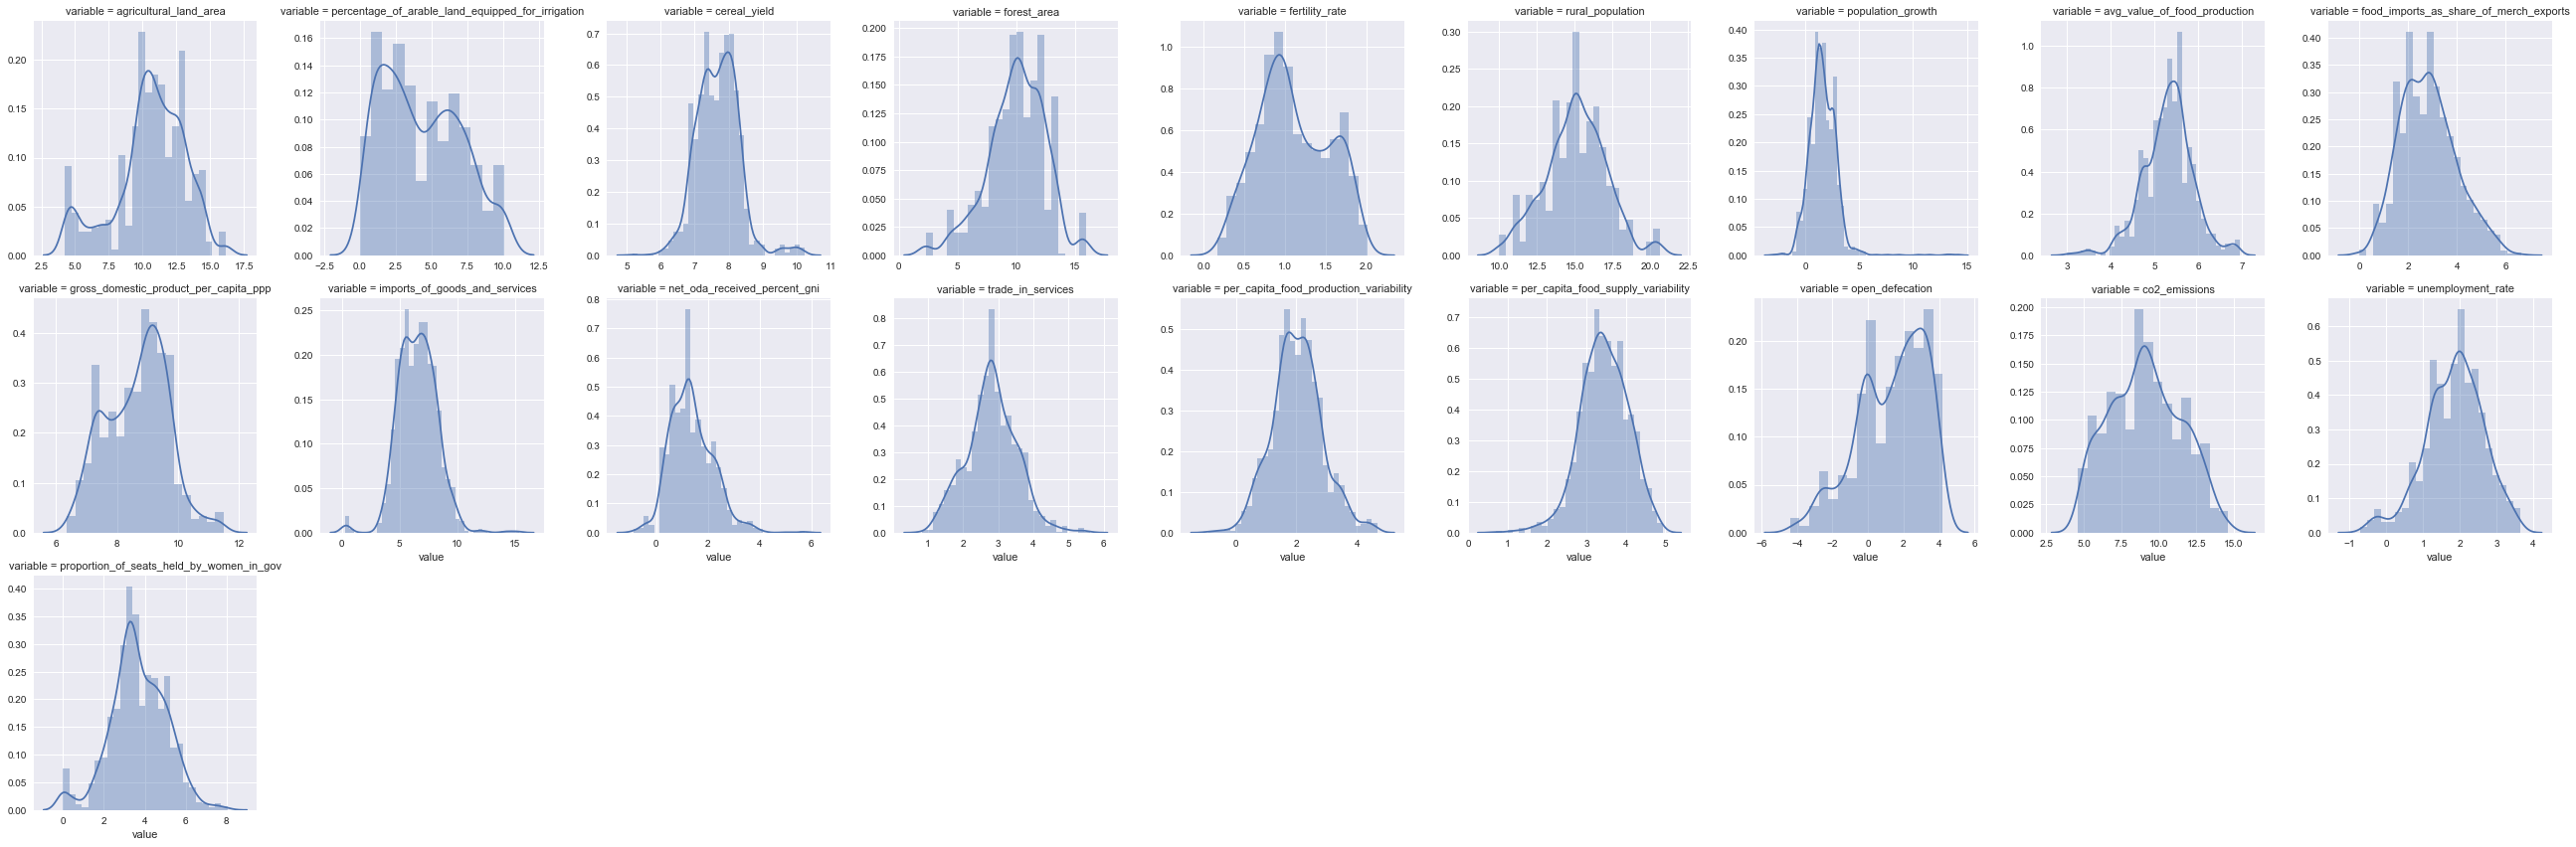

In [36]:
facet_plotting(train, skewed)

The transformation on skewed data resulted in much more normally distributed variables, which turns out improve the accuracy of SVM regression.

In [37]:
def left_skewed_transformation(data): 
    
    # List of right_skewed features
    skewed = data[data.columns[2:]].apply(lambda x: ss.skew(x.astype(float)))
    left_skewed = skewed[skewed < -0.75]
    left_skewed = left_skewed.index

    # Change range to limit values at 100:
    for col in left_skewed[1:]:
        OldRange = (max(data[col]) - min(data[col]))
        NewRange = 100 - min(data[col])
        data[col] = data[col].map(lambda x: ((x - min(data[col])) * NewRange)/ OldRange) + min(data[col])

    # Create reverse variables
    data['adult_illiteracy_rate'] = 100 - data['adult_literacy_rate']
    data['no_electricity'] = 100 - data['access_to_electricity']
    data['no_school_rate'] = 100 - data['school_enrollment_rate_female']
    data['no_access_water_sources'] = 100 - data['access_to_improved_water_sources']

    # Drop the initial features
    data.drop(['adult_literacy_rate', 'access_to_electricity', 'school_enrollment_rate_female',
                'access_to_improved_water_sources'], axis=1, inplace=True)

    # Create list of new features
    new = ['adult_illiteracy_rate', 'no_electricity', 'no_school_rate', 'no_access_water_sources']

    # Log Transform the reversed left_skewed features
    for col in new:
        data[col] = data[col].map(lambda x: np.log1p(x))
        
left_skewed_transformation(train)
left_skewed_transformation(test)

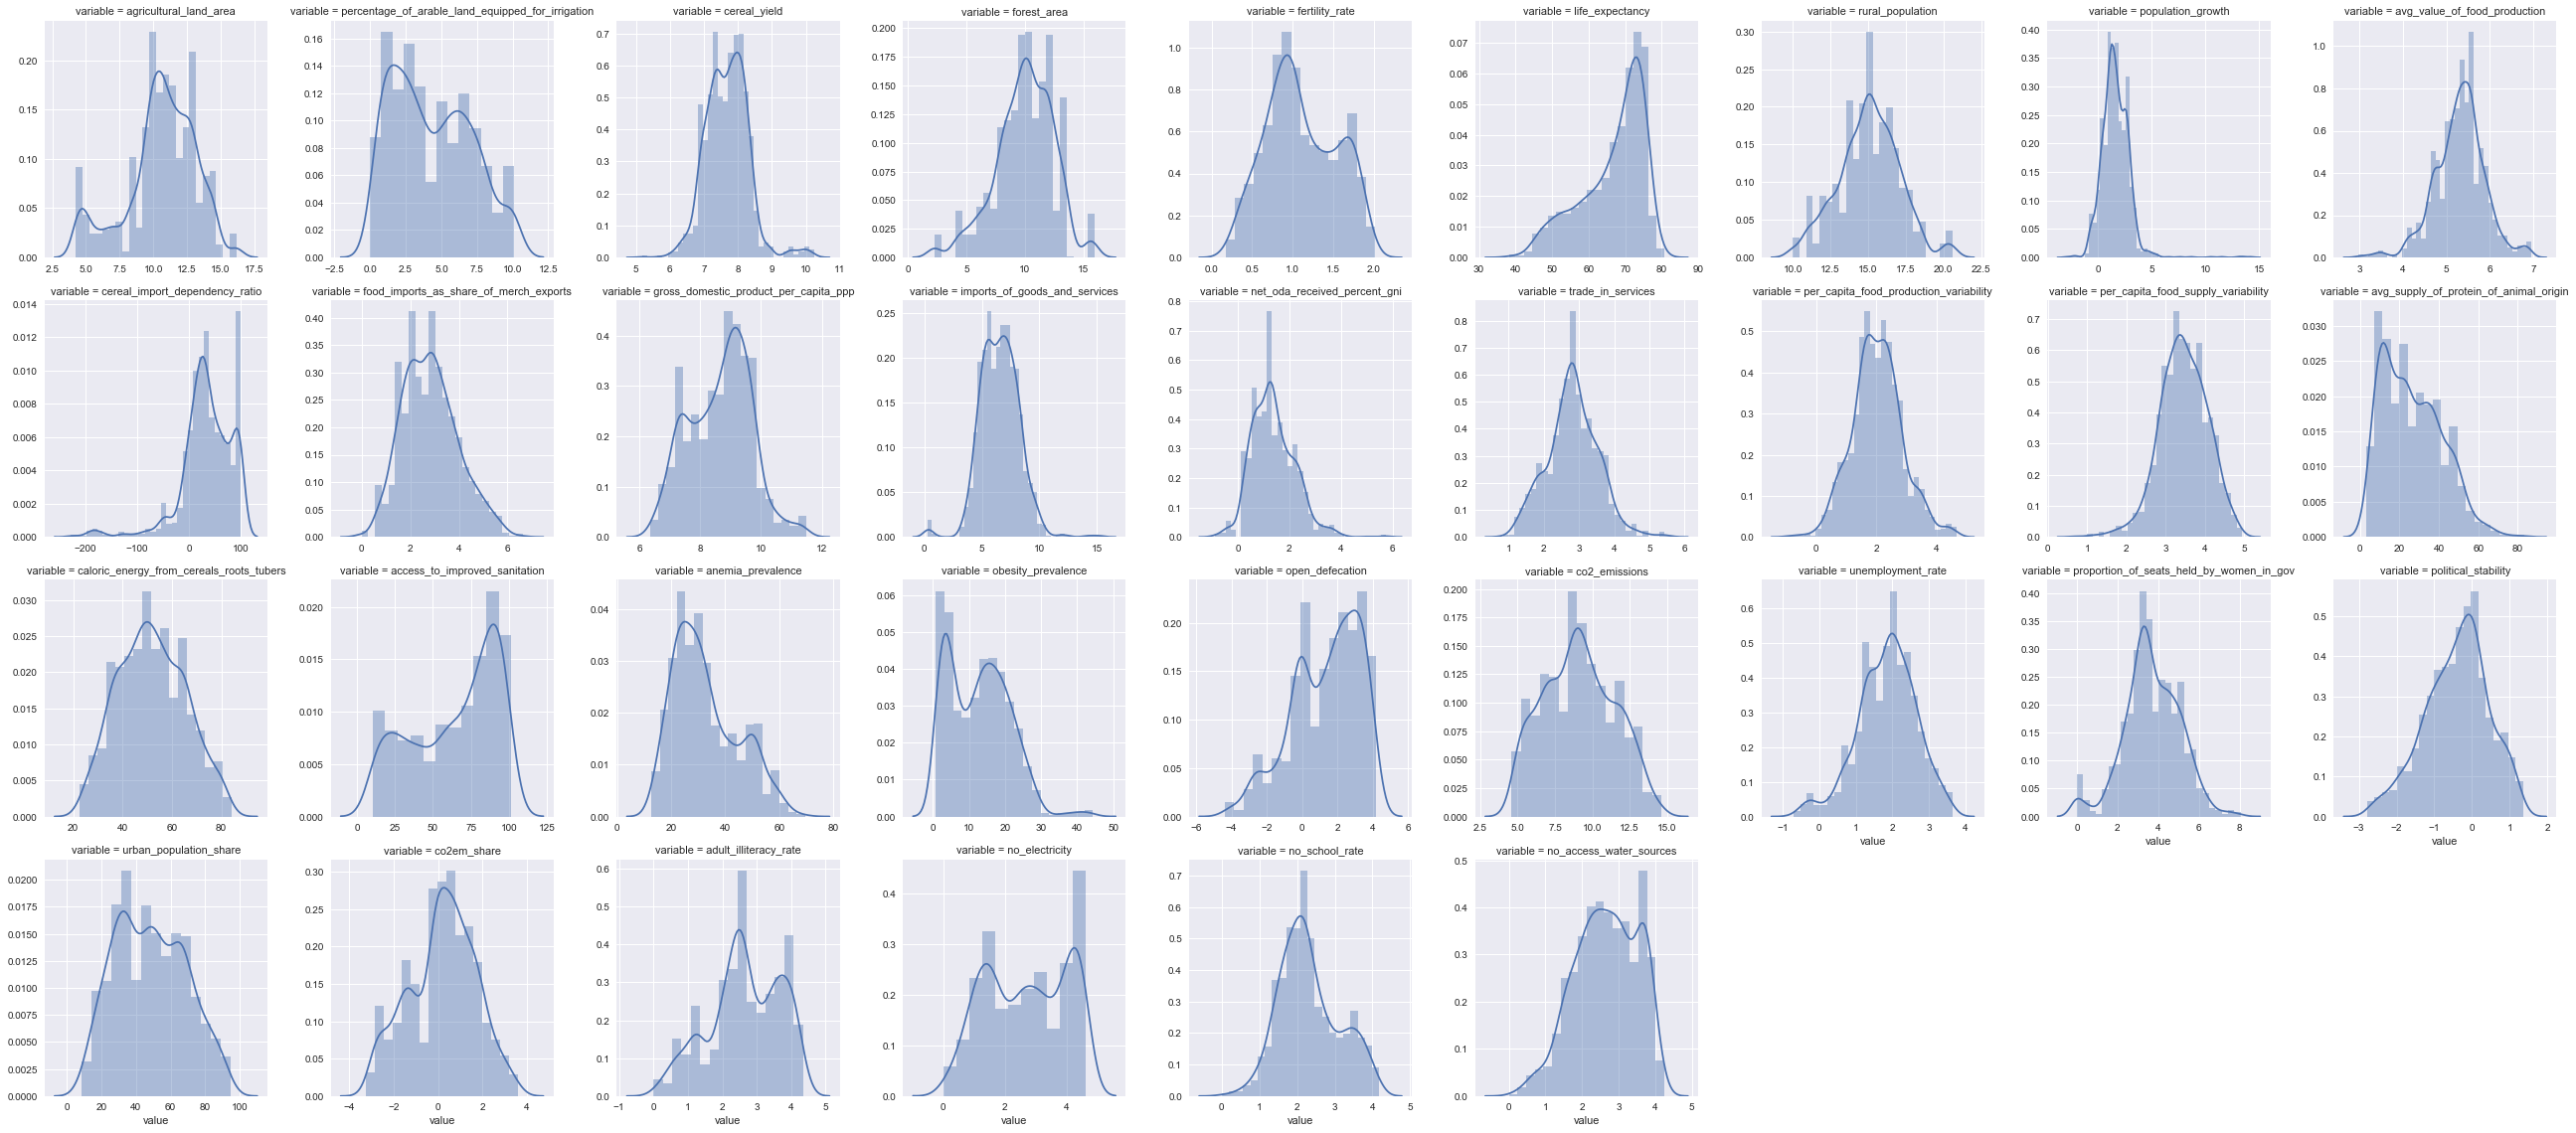

In [38]:
facet_plotting(train, train.columns[2:])

In [39]:
# train.drop('undernourishment', axis=1, inplace = True)
train.to_csv('Unskewed_Train.csv')
test.to_csv('Unskewed_Test.csv')

## Summary:

- We filled missing values trying to remove and introduce respectively as little information and bias as possible by interpolation chronologically ordered countries series, remove the features with either too many missing values or too weakly correlated with the dependant variable undernourishment.
- We inspected the distribution of the variables, and got few first insights about what kind of algorithms to use.
- We checked for low variances, collinearity, and created 2 new features that seems to be have interesting relationship with 'undernourishment'.
- Considering we plan to use Support Vector Machine Regressor, we create a last version with corrected skewness, which implied different trasnformation method (cbrt, sqrt, log, log1p)